# Задача

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor
from catboost import cv
from catboost import train
import lightgbm

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
%matplotlib inline

#  Подготовка данных

In [2]:
df = pd.read_csv('autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

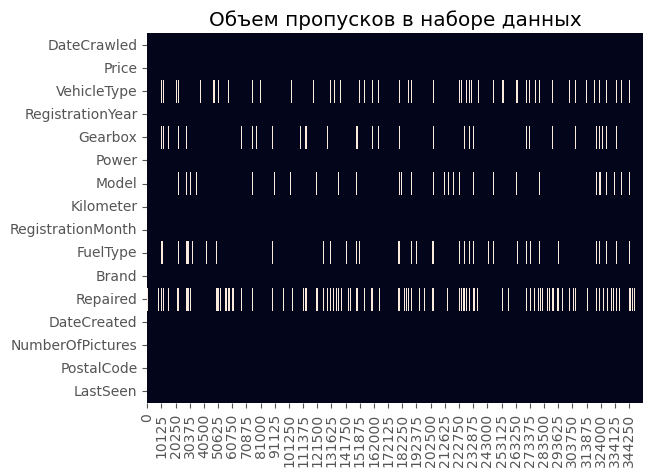

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
Repaired             0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [5]:
sns.heatmap(df.isna().T, cbar=False).set_title('Объем пропусков в наборе данных')
plt.show()
df.isna().mean()

In [6]:
df['VehicleType'] = df['VehicleType'].fillna(df['VehicleType'].mode().values[0])
df['Gearbox'] = df['Gearbox'].fillna(df['Gearbox'].mode().values[0])
df['Model'] = df['Model'].fillna(df['Model'].mode().values[0])
df['FuelType'] = df['FuelType'].fillna(df['FuelType'].mode().values[0])
df['Repaired'] = df['Repaired'].fillna('no') 

In [7]:
df.isna().mean()

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
Repaired             0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

## Проверка наличия дубликатов

In [8]:
col_categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired'] 
print(pd.Series([pd.Series(df[col].unique()).str.lower().duplicated().sum() \
                 for col in col_categorical], index=col_categorical))

VehicleType    0
Gearbox        0
Model          0
FuelType       0
Repaired       0
dtype: int64


In [9]:
print(f'Кол-во дубликатов: {df.duplicated().sum()}')

Кол-во дубликатов: 5


In [10]:
df = df.drop_duplicates()
print(f'Кол-во дубликатов: {df.duplicated().sum()}')

Кол-во дубликатов: 0


## Исследуем данные

In [11]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DateCrawled,354364,271174,2016-03-24 14:49:47,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,354364.0,NaN,NaN,NaN,4416.655608,4514.15969,0.0,1050.0,2700.0,6400.0,20000.0
VehicleType,354364,8,sedan,128946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,354364.0,NaN,NaN,NaN,2004.234471,90.228593,1000.0,1999.0,2003.0,2008.0,9999.0
Gearbox,354364,2,manual,288081,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,354364.0,NaN,NaN,NaN,110.093723,189.85159,0.0,69.0,105.0,143.0,20000.0
Model,354364,250,golf,48937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,354364.0,NaN,NaN,NaN,128211.373051,37905.136957,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354364.0,NaN,NaN,NaN,5.714641,3.726433,0.0,3.0,6.0,9.0,12.0
FuelType,354364,7,petrol,249244,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_all = df.copy()
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode'], axis = 1)

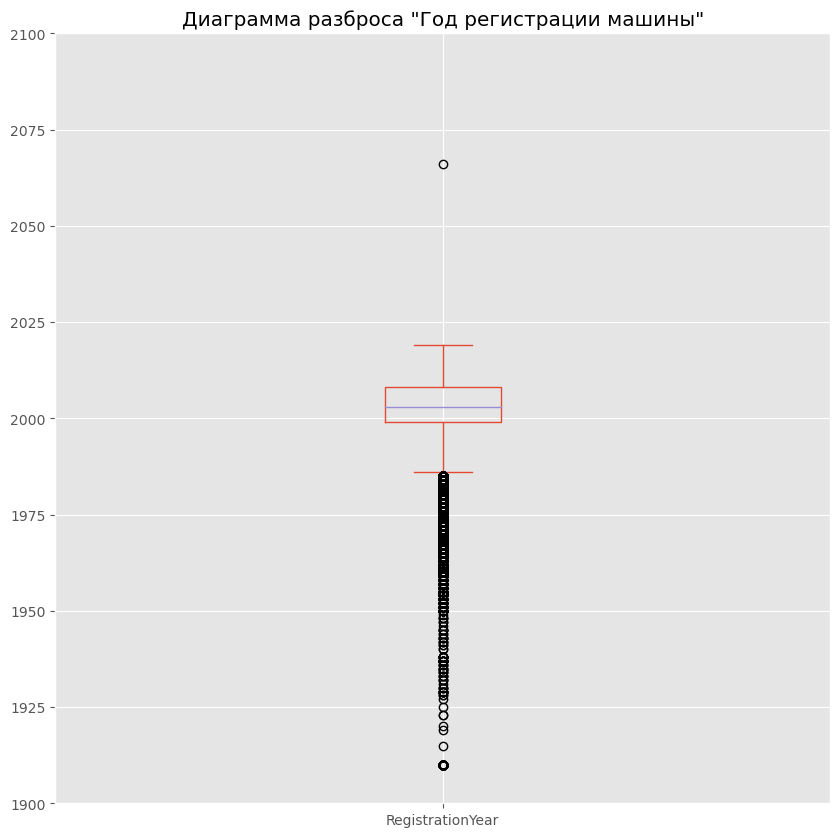

In [13]:
df['RegistrationYear'].plot(kind='box',figsize=(10, 10), grid=True, title='Диаграмма разброса "Год регистрации машины"')
plt.ylim((1900, 2100))
plt.show()

In [14]:
def RangeRegistrationYear(value):
    if value > 2022:
        return 2022
    elif value < 1958:
        return 1958
    else:
        return value

In [15]:
df['RegistrationYear'] = df['RegistrationYear'].apply(RangeRegistrationYear)
df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'] = 1

In [16]:
def outlier(df, col):
    min_q = np.array(df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))
    max_q = np.array(df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))
    df = df[(df[col] >= min_q) & (df[col] <= max_q)]
    
    return df

In [17]:
columns = ['Price', 'Power']
for column in columns:
    size = df.shape[0]
    df = outlier(df, column)
    print('Кол-во строк было удалено в столбце '+str(column)+':', (size - df.shape[0]))

Кол-во строк было удалено в столбце Price: 18979
Кол-во строк было удалено в столбце Power: 5153


In [18]:
cat_features = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired', 'Model']
encoder = OrdinalEncoder(dtype=np.int16)
encoder.fit(df[cat_features])
df[cat_features] = encoder.transform(df[cat_features])
df = df.astype(np.int16)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330232 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Price              330232 non-null  int16
 1   VehicleType        330232 non-null  int16
 2   RegistrationYear   330232 non-null  int16
 3   Gearbox            330232 non-null  int16
 4   Power              330232 non-null  int16
 5   Model              330232 non-null  int16
 6   Kilometer          330232 non-null  int16
 7   RegistrationMonth  330232 non-null  int16
 8   FuelType           330232 non-null  int16
 9   Brand              330232 non-null  int16
 10  Repaired           330232 non-null  int16
dtypes: int16(11)
memory usage: 9.4 MB


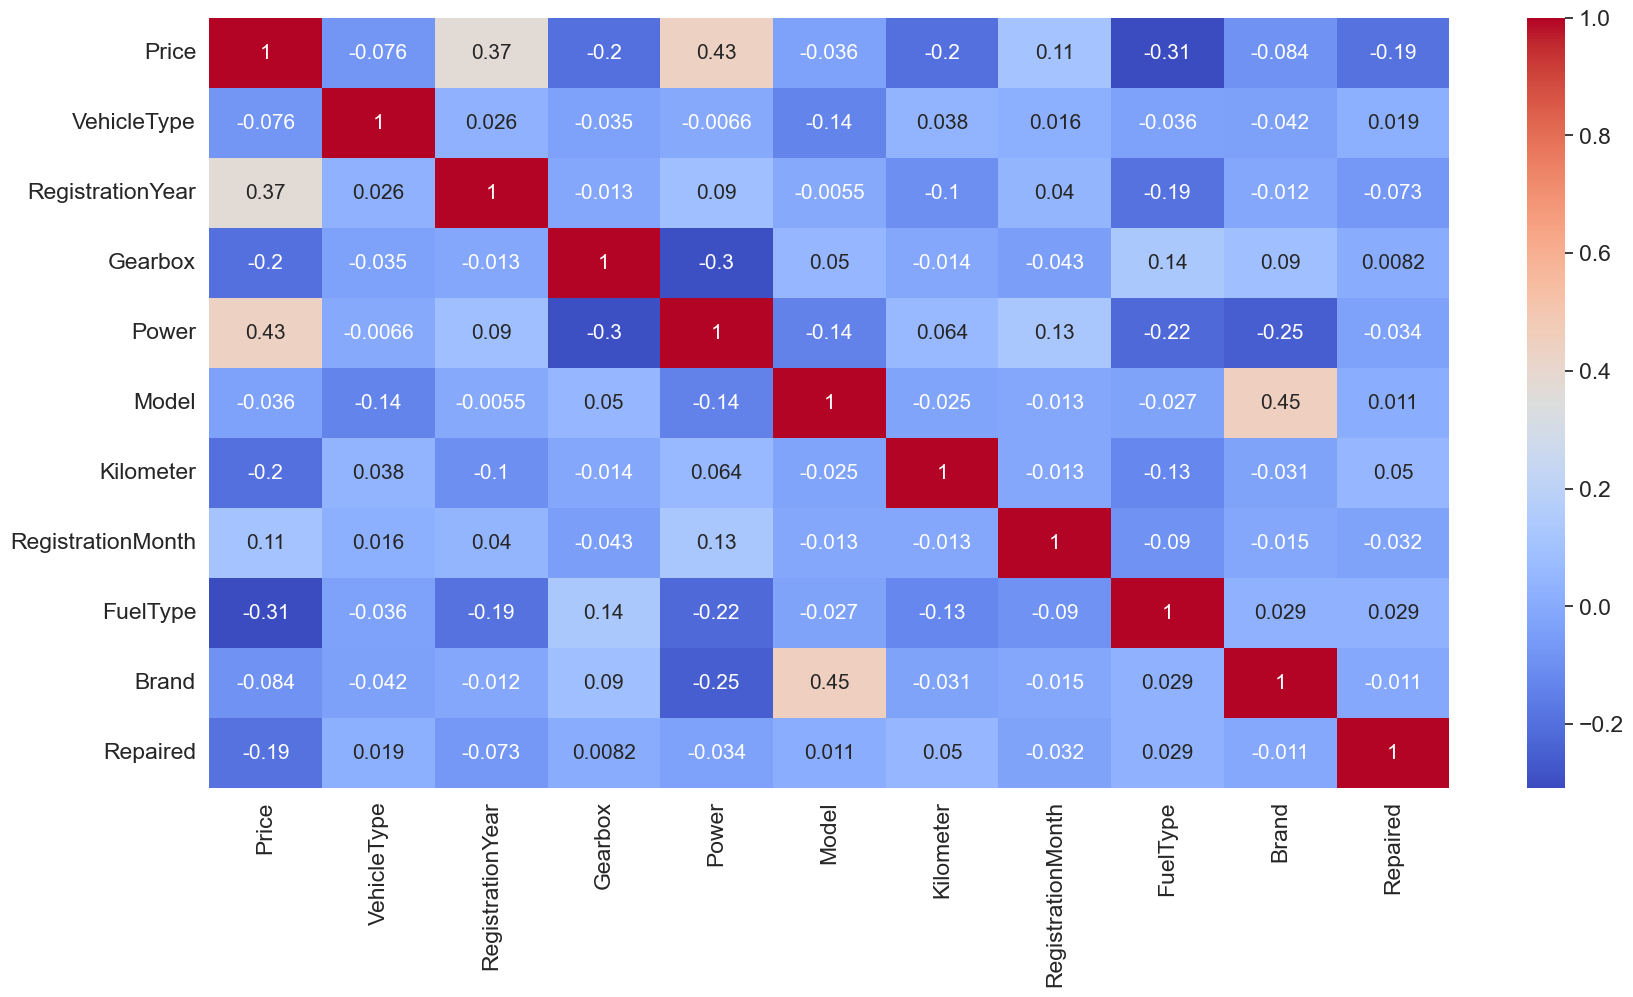

In [19]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
sns.heatmap(df.corr(), annot=True, fmt='.2g', cmap= 'coolwarm', annot_kws={"fontsize":15});

# Разделим и закодируем выборки

In [20]:
SEED = 12345

In [21]:
target = df[['Price']]
features = df.drop(['Price'], axis=1)

In [22]:
features_80, features_test, target_80, target_test = train_test_split(
    features, target, test_size=.2, random_state=SEED)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_80, target_80, test_size=.25, random_state=SEED)
print(features_train.shape, target_train.shape, features_valid.shape, target_valid.shape, features_test.shape, target_test.shape)

(198138, 10) (198138, 1) (66047, 10) (66047, 1) (66047, 10) (66047, 1)


#  Нахождение наилучших парметров моделей

Модель `CatBoost`

In [23]:
def rmse(test, predict):
    return ((mean_squared_error(test, predict)) ** 0.5).round(2)

In [24]:
"""
model_cb = CatBoostRegressor(random_state=SEED, cat_features=cat_features)
params_cb = {
    'iterations' :  [40],
    'max_depth' : np.arange(4, 16, 4),
    'learning_rate' : [.1, .3, .4, .7, 1]
}
gs_cb = model_cb.grid_search(params_cb, features_train, target_train, plot=True)
"""

"\nmodel_cb = CatBoostRegressor(random_state=SEED, cat_features=cat_features)\nparams_cb = {\n    'iterations' :  [40],\n    'max_depth' : np.arange(4, 16, 4),\n    'learning_rate' : [.1, .3, .4, .7, 1]\n}\ngs_cb = model_cb.grid_search(params_cb, features_train, target_train, plot=True)\n"

In [25]:
print('Наилучшие параметры модели CatBoost: 12')
print(f'RMSE-test = {1498.91511}')

Наилучшие параметры модели CatBoost: 12
RMSE-test = 1498.91511


Модель `Дерево решений`

In [26]:
model_dt = DecisionTreeRegressor(random_state=SEED)
params_dt = {
    'max_depth' : np.arange(1, 15, 1),
    'min_samples_leaf' : np.arange(1, 5),
   #'class_weight' : ['balanced']
}
gs_dt = GridSearchCV(model_dt, params_dt, cv=3)
gs_dt.fit(features_train, target_train)
pred_valid = gs_dt.predict(features_valid)
result = mean_squared_error(target_valid, pred_valid) ** .5
print('Max depth =', gs_dt.best_params_.get('max_depth'), '; '
      'Min samples leaf =', gs_dt.best_params_.get('min_samples_leaf'))
print('RMSE', result)

Max depth = 14 ; Min samples leaf = 4
RMSE 1686.3299146627508


Модель `LightGBM`

In [27]:
lgbm_train_data = lightgbm.Dataset(features_train, label=target_train)

arguments = {'learning_rate': 1,
         'metric': 'rmse',
         'seed': SEED,
         'objective': 'regression',
         'verbosity': -1,
        }

max_depth = [1, 6, 11, 16]

In [28]:
best_score = 2500
for depth in max_depth:
    arguments['max_depth'] = depth
    score = lightgbm.cv(arguments, lgbm_train_data, nfold=5, categorical_feature=cat_features)
    score = pd.DataFrame(score).iloc[-1]['rmse-mean']
    if score < best_score:
        best_score = score
        best_depth = depth

In [29]:
arguments['max_depth'] = best_depth
lgbm_model = lightgbm.train(arguments, lgbm_train_data, categorical_feature=cat_features, num_boost_round=400)
print(f'Глубина модели: {best_depth}\nRMSE: {round(best_score, 5)}') 

Глубина модели: 6
RMSE: 1538.9119


### Вывод
* RMSE модели `CatBoost` = 1498.91511
* RMSE модели `Дерево решений` = 1686.32991
* RMSE модели `LightGBM` = 1538.9119

# Обучение модели и выявления показателей моделей

## CatBoostRegressor

#### Время обучения:

In [30]:
%%time
start = time.time()
model_cat = CatBoostRegressor(random_state=SEED,learning_rate=0.4, verbose=100, n_estimators=1000)
model_cat.fit(features_train, target_train)
end = time.time()
time_train_cat=round(end-start, 2)

0:	learn: 2673.6205098	total: 79ms	remaining: 1m 18s
100:	learn: 1488.7861373	total: 3.71s	remaining: 33s
200:	learn: 1424.6794815	total: 6.13s	remaining: 24.4s
300:	learn: 1386.5564781	total: 8.57s	remaining: 19.9s
400:	learn: 1359.2561330	total: 11.7s	remaining: 17.5s
500:	learn: 1336.7328788	total: 14.2s	remaining: 14.1s
600:	learn: 1318.0622891	total: 16.6s	remaining: 11s
700:	learn: 1300.9964052	total: 18.9s	remaining: 8.07s
800:	learn: 1287.6593552	total: 21.2s	remaining: 5.26s
900:	learn: 1274.8432839	total: 23.7s	remaining: 2.6s
999:	learn: 1263.4665832	total: 25.9s	remaining: 0us
Wall time: 26.2 s


#### Скорость предсказания:

In [31]:
%%time
start = time.time()
predict_cat=model_cat.predict(features_valid)
end = time.time()
time_pred_cat=round(end-start, 2)

Wall time: 55 ms


#### Качество RMSE:

In [32]:
rmse_cat = rmse(target_valid, predict_cat)
print(f'RMSE = {rmse_cat}')

RMSE = 1441.74


# DecisionTreeRegressor

#### Время обучения:

In [33]:
%%time
start = time.time()
model_dtr = DecisionTreeRegressor(random_state=SEED, max_depth=14, min_samples_leaf=4)
model_dtr.fit(features_train, target_train)
end = time.time()
time_train_dt = round(end-start,2)

Wall time: 593 ms


#### Скорость предсказания:

In [34]:
%%time
start = time.time()
predict_dtr = model_dtr.predict(features_valid)
end = time.time()
time_pred_dt = round(end-start, 2)

Wall time: 20 ms


#### Качество RMSE:

In [35]:
rmse_dtr = rmse(target_valid, predict_dtr)
print(f'RMSE = {rmse_dtr}')

RMSE = 1686.33


# LightGBM

#### Время обучения:

In [36]:
%%time
start = time.time()
model_lgb = lightgbm.sklearn.LGBMRegressor(n_estimators=1000, max_depth=6, random_state=SEED, learning_rate=0.4, objective='rmse')
model_lgb.fit(features_train, target_train)
end = time.time()
time_train_lgb=round(end-start, 2)

Wall time: 6.2 s


#### Скорость предсказания:

In [37]:
%%time
start = time.time()
predict_lgb= model_lgb.predict(features_valid)
end = time.time()
time_pred_lgb=round(end-start, 2)

Wall time: 2.27 s


#### Качество RMSE:

In [38]:
rmse_lgb=rmse(target_valid, predict_lgb)
print(f'RMSE = {rmse_lgb}')

RMSE = 1443.5


#  Анализ моделей

In [39]:
column=['RMSE модели', 'Скорость обучения, сек','Скорость предсказания, сек']
table = pd.DataFrame(index=['Скорость обучения, сек', 'Скорость предсказания, сек','RMSE модели'], columns=['LightGBM', 'DecisionTreeRegressor','CatBoostRegressor'])
table['CatBoostRegressor'] = time_train_cat, time_pred_cat, rmse_cat
table['DecisionTreeRegressor'] = time_train_dt, time_pred_dt, rmse_dtr
table['LightGBM'] = time_train_lgb, time_pred_lgb, rmse_lgb

display(table)

,LightGBM,DecisionTreeRegressor,CatBoostRegressor
"Скорость обучения, сек",6.20,0.59,26.24
"Скорость предсказания, сек",2.27,0.02,0.05
RMSE модели,1443.50,1686.33,1441.74


### Вывод
Из проведнного анализа целесообразно выбрать модель `LightGBM`, скорости обучения и предсказания приемлемые по времени ожидания, а главное, что оценка RMSE имеет хороший показатель

### Проверка на тестовой выборке

In [41]:
model_lgbm = lightgbm.sklearn.LGBMRegressor(n_estimators=1000, max_depth=6, random_state=SEED, learning_rate=0.4, objective='rmse')
model_lgbm.fit(features_80, target_80)
predictions_test_lgbm = model_lgbm.predict(features_test)
print(f'RMSE = {rmse(target_test, predictions_test_lgbm)}')

RMSE = 1436.16


### Вывод
Качество предсказаний на тестовой выборке получилось лучше чем на валидацинной